# Standardization of clinical data

To prepare the data for the AJIVE procedure we will transform most of the numeric variables using the Automatic Shifted Log transformation, to reduce skewness and reduce the effect of outliers

In [1]:
from autoshiftedlog import autoshiftedlog
import joblib
import matplotlib.pyplot as plt
import xarray
xarray.set_options(keep_attrs=True);

In [2]:
oai_xr = xarray.open_zarr('processed_data/processed_oai_clinical.zarr/')

In [3]:
oai_xr

<xarray.Dataset>
Dimensions:       (knee: 6317)
Coordinates:
    patient_id    (knee) int64 dask.array<chunksize=(6317,), meta=np.ndarray>
    side          (knee) <U5 dask.array<chunksize=(6317,), meta=np.ndarray>
Dimensions without coordinates: knee
Data variables: (12/77)
    Asian race    (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    Black race    (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    BothHP12      (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    BothHRS       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    Female Sex    (knee) int64 dask.array<chunksize=(6317,), meta=np.ndarray>
    Is Married    (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    ...            ...
    V00eSFP       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    V00eSFR       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    V00fSFP       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    V00fSFR       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    V00fmaxf      (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    White race    (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>

In [4]:
for name, data_array in oai_xr.items():
    if data_array.attrs['var_type']=='numeric':
        print(name)


MaxDrinksWk
P01BMI
V0020MPACE
V00400MTIM
V00AGE
V00BPDIAS
V00BPSYS
V00CESD
V00COMORB
V00CSPACE
V00HSMSS
V00HSPSS
V00KALNMT
V00KFHDEG
V00KOOSKP
V00KOOSYM
V00LWGT
V00PASE
V00RX30NUM
V00WOMADL
V00WOMKP
V00WOMSTF
V00eSFP
V00eSFR
V00fSFP
V00fSFR
V00fmaxf


In [5]:
for name, data_array in oai_xr.items():
    if data_array.attrs['var_type']=='ordinal':
        print(name)


P01KSX
V00EDCV
V00EXP1CV
V00FXP1CV


In [6]:
Shifted_MaxDrinksWk = autoshiftedlog(oai_xr['MaxDrinksWk'])

(array([1074.,    0.,    0., 2362.,    0.,  972.,    0.,  999.,  621.,
         289.]),
 array([-1.57233702, -1.21640777, -0.86047853, -0.50454928, -0.14862004,
         0.20730921,  0.56323845,  0.9191677 ,  1.27509694,  1.63102619,
         1.98695544]),
 <BarContainer object of 10 artists>)

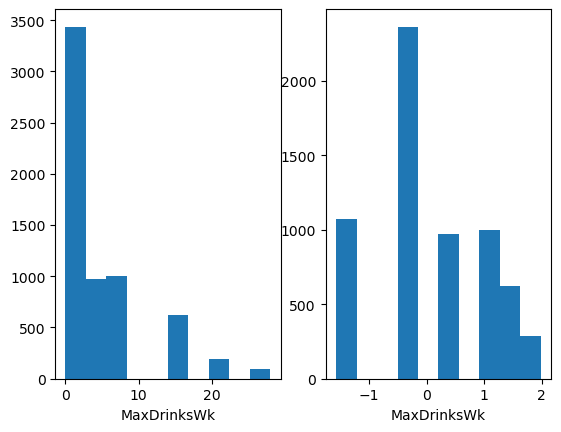

In [7]:
plt.subplot(121)
oai_xr['MaxDrinksWk'].plot.hist()
plt.subplot(122)
Shifted_MaxDrinksWk.plot.hist()

In [8]:
ShiftedEDCV = autoshiftedlog(oai_xr['V00EDCV'])

(array([ 154.,    0.,  736.,    0., 1403., 1425.,    0.,    0.,  556.,
        2043.]),
 array([-2.13919886, -1.80563549, -1.47207212, -1.13850875, -0.80494539,
        -0.47138202, -0.13781865,  0.19574472,  0.52930809,  0.86287146,
         1.19643483]),
 <BarContainer object of 10 artists>)

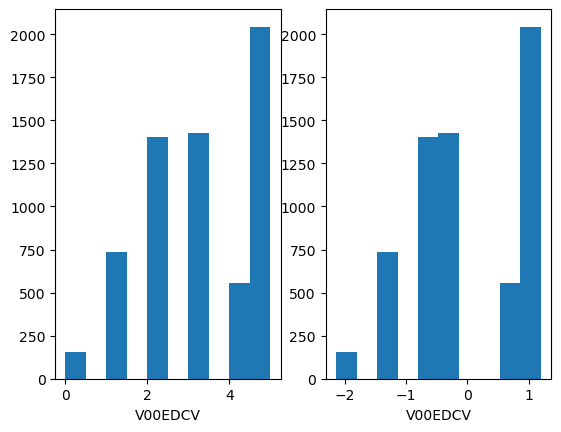

In [9]:
plt.subplot(121)
oai_xr['V00EDCV'].plot.hist()
plt.subplot(122)
ShiftedEDCV.plot.hist()

Based on discussion with Dr. Marron, we replace all numeric and ordinal features with these transformed versions, except for WOMAC Stiffness and Comorbidity Score:

In [10]:
to_transform = ["MaxDrinksWk", "P01BMI", "V0020MPACE", "V00400MTIM", "V00AGE", "V00BPDIAS", "V00BPSYS", 
                "V00CESD", "V00CSPACE", "V00HSMSS", "V00HSPSS", "V00KALNMT", "V00KFHDEG", 
                "V00KOOSKP", "V00KOOSYM", "V00LWGT", "V00PASE", "V00RX30NUM", "V00WOMADL", "V00WOMKP", 
                "V00eSFP", "V00eSFR", "V00fSFP", "V00fSFR", "V00fmaxf", 
                "P01KSX", "V00EDCV", "V00EXP1CV", "V00FXP1CV"]

In [11]:
res = joblib.Parallel(n_jobs=-2, verbose=10)(
    joblib.delayed(autoshiftedlog)(oai_xr[x]) for x in to_transform
)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-2)]: Done  27 out of  29 | elapsed: 12.6min remaining:   55.9s
[Parallel(n_jobs=-2)]: Done  29 out of  29 | elapsed: 13.5min finished


Observe that the `Attributes` were not preserved. We'll make sure to add them back in.

In [12]:
res[0]

<xarray.DataArray 'MaxDrinksWk' (knee: 6317)>
dask.array<truediv, shape=(6317,), dtype=float64, chunksize=(6317,), chunktype=numpy.ndarray>
Coordinates:
    patient_id  (knee) int64 dask.array<chunksize=(6317,), meta=np.ndarray>
    side        (knee) <U5 dask.array<chunksize=(6317,), meta=np.ndarray>
Dimensions without coordinates: knee

In [13]:
for dataarray in res:
    name = dataarray.name
    old_attrs = oai_xr[name].attrs
    oai_xr[name] = dataarray.assign_attrs(old_attrs)

(array([1074.,    0.,    0., 2362.,    0.,  972.,    0.,  999.,  621.,
         289.]),
 array([-1.57233702, -1.21640777, -0.86047853, -0.50454928, -0.14862004,
         0.20730921,  0.56323845,  0.9191677 ,  1.27509694,  1.63102619,
         1.98695544]),
 <BarContainer object of 10 artists>)

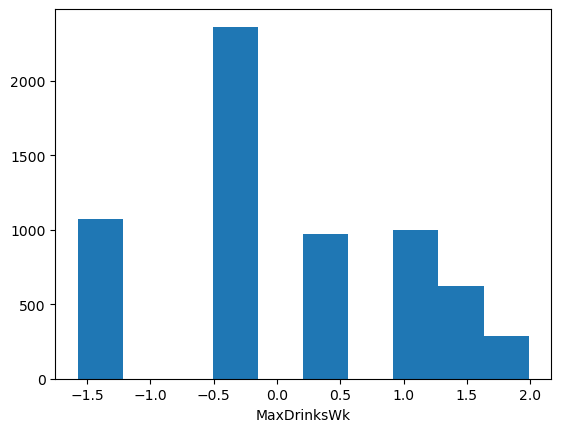

In [14]:
oai_xr['MaxDrinksWk'].plot.hist()

# Save to Zarr store

In [15]:
oai_xr

<xarray.Dataset>
Dimensions:       (knee: 6317)
Coordinates:
    patient_id    (knee) int64 dask.array<chunksize=(6317,), meta=np.ndarray>
    side          (knee) <U5 dask.array<chunksize=(6317,), meta=np.ndarray>
Dimensions without coordinates: knee
Data variables: (12/77)
    Asian race    (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    Black race    (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    BothHP12      (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    BothHRS       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    Female Sex    (knee) int64 dask.array<chunksize=(6317,), meta=np.ndarray>
    Is Married    (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    ...            ...
    V00eSFP       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    V00eSFR       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    V00fSFP       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    V00fSFR       (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    V00fmaxf      (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>
    White race    (knee) float64 dask.array<chunksize=(6317,), meta=np.ndarray>

In [16]:
oai_xr.to_zarr('processed_data/processed_oai_clinical_std.zarr')